In [ ]:
import numpy as np
import pandas as pd
import os
import nltk
from sklearn.metrics import confusion_matrix #karmaşıklık matrisi
from sklearn.model_selection import GridSearchCV # Veriyi gridlere ayırmak
from sklearn.model_selection import train_test_split # eğitim ve test verisi ayır
from sklearn.feature_extraction.text import TfidfVectorizer # Destek vektör makineleri vektörlere ayırıcı
from sklearn.model_selection import cross_val_score,cross_validate
from sklearn.metrics import make_scorer, accuracy_score, f1_score, precision_score, recall_score
from nltk.tokenize import word_tokenize # stemming için metini kelimelere ayırır
from TurkishStemmer import TurkishStemmer # Kök bulma fonksiyonu (stemming)
from sklearn.svm import SVC # Destek vektör algoritması
import matplotlib.pyplot as plt # Grafik çizdirici
import seaborn as sns; sns.set() # Grafik çizdirici

Veri seti 3 duygu etiketinden oluşmaktadır. Bu etiketler nötr, negatif ve pozitif'tir. Buna göre, nötr ifadeler 0 ile, negatifler 1 ile ve pozitifler 2 ile etiketlenmiştir.

In [ ]:
df=pd.read_excel('TurkceTwitler.xlsx')  
df.tail()

,Tweet,Etiket
3995,Aynı şeyleri yapmaktan sıkıldım,1
3996,"Olacağı varsa oluyor ya hani, biteceği varsa d...",1
3997,Çok şey istiyorum ama sonu hep fiyasko MUTSUZUM,1
3998,Garip bir şekilde canım çok yanıyor moralim bozuk,1
3999,1üm birazdan takipten çıkarıp hesabımı gizliye...,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Tweet   3999 non-null   object
 1   Etiket  4000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 62.6+ KB


Eksik veri var ise çıkartıyoruz.

In [ ]:
df = df[df['Tweet'].notnull()]

2399 adet negatif,
800 adet pozitif,
800 adet nötr kategoride verimiz bulunuyor.

In [ ]:
df['Etiket'].value_counts()

1    2399
2     800
0     800
Name: Etiket, dtype: int64

Algoritmayı Uygulamadan önce verileri hazırlamak çok önemlidir.Bu işleme veri önişleme denir.

Kendimizin oluşturduğu anlam ifade etmeyen kelimeleri (`ama`, `ve`, `ile`,...) stopTr.txt dosyamızdan alıyoruz.

In [ ]:
with open("stopTr.txt", "r") as d:
    durak = d.read() 

Verilerimizden anlam ifade etmeyen kelimeleri çıkarmak için bir fonksiyon tanımladık.

In [ ]:
def metin_on_isleme(metin):
    metin = [word for word in metin.split() if word not in durak]
    return " ".join(metin)

Metin ön işleme fonksiyonumuzu kullanarak yeni twitlerimizi oluşturup, durak isimli bir sütun oluşturup kaydediyoruz.

In [ ]:
df['durak'] = df['Tweet'].apply(metin_on_isleme)
df.tail(10)

,Tweet,Etiket,durak
3990,Bu ara hiç iyi uyuyamıyorum çok mutsuzum,1,uyuyamıyorum mutsuzum
3991,Çok yıprandım artık lisansı bitirip işsiz kald...,1,yıprandım lisansı bitirip işsiz kaldığım evrey...
3992,Çok enteresan bir şey oldu. Kıvanç Tatlıtuğ'u ...,1,enteresan oldu. Kıvanç Tatlıtuğ'u özledim.
3993,"Biraz seni özledim, biraz sohbetini, biraz ses...",1,"Biraz özledim, sohbetini, sesini."
3994,Ben sadece artık yalanlarınızdan yoruldum. Siz...,1,yalanlarınızdan yoruldum. Sizi kötü hatırlamak...
3995,Aynı şeyleri yapmaktan sıkıldım,1,şeyleri yapmaktan sıkıldım
3996,"Olacağı varsa oluyor ya hani, biteceği varsa d...",1,"Olacağı varsa hani, biteceği varsa bitsin. YOR..."
3997,Çok şey istiyorum ama sonu hep fiyasko MUTSUZUM,1,istiyorum fiyasko MUTSUZUM
3998,Garip bir şekilde canım çok yanıyor moralim bozuk,1,Garip canım yanıyor moralim bozuk
3999,1üm birazdan takipten çıkarıp hesabımı gizliye...,1,takipten çıkarıp hesabımı gizliye alıcağım faz...


Stemming (Kök alma) algoritmaları , ekli kelimede bulunabilecek yaygın ve son eklerin bir listesini dikkate alarak kelimenin başlangıcını kesmeye çalışır. Biz bu algoritmalardan Türkçe için kullanılan TurkishStemmer kütüphanesini kullandık.

In [ ]:
stemmer = TurkishStemmer()

Kökleri bulucak fonksiyonu tanımladık.

In [ ]:
def kok_bul(metin):
    kelimeler=word_tokenize(metin)
    kokler=[]
    for k in kelimeler:
        kokler.append(stemmer.stem(k))
        
    return ' '.join(kokler)

Durak sütunumuza kok_bul fonksiyonumuzu uygulayıp, yeni twitleri kokler sütununa kaydettik.

In [ ]:
df['kokler'] = df['durak'].apply(kok_bul)
df.tail()

,Tweet,Etiket,durak,kokler
3995,Aynı şeyleri yapmaktan sıkıldım,1,şeyleri yapmaktan sıkıldım,şey yapmak sıkıl
3996,"Olacağı varsa oluyor ya hani, biteceği varsa d...",1,"Olacağı varsa hani, biteceği varsa bitsin. YOR...","Olacağı var hani , bitecek var bits . YORULDUM"
3997,Çok şey istiyorum ama sonu hep fiyasko MUTSUZUM,1,istiyorum fiyasko MUTSUZUM,istiyor fiyasko MUTSUZUM
3998,Garip bir şekilde canım çok yanıyor moralim bozuk,1,Garip canım yanıyor moralim bozuk,Garip can yanıyor moralim bozuk
3999,1üm birazdan takipten çıkarıp hesabımı gizliye...,1,takipten çıkarıp hesabımı gizliye alıcağım faz...,takip çıkarıp hesap giz alıcak fazl çekme


Verimizi test ve eğitim verisi olarak ayırdık. Test verisi boyutunu %20 olarak ayarladık. (3200 veri eğitim, 800 veri test olarak ayarlandı.) 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['kokler'],df['Etiket'],test_size=0.2, random_state = 1)

Burada kelimeleri TF-IDF (Term Frequency - Inverse Document Frequency ) terim ağırlıklandırma yöntemini kullandık.TF-TDF, verideki bir kelimenin kuvvetini, o kelimeyi içeren belge sayısına ve belge sayısına göre hesaplayan bir ağırlıklandırma yöntemidir.Verilerdeki önemsiz değerler elimine edilir, önemli özellikler belirlenir ve sınıflandırma işlemi sırasında performansta artış sağlanır.Bir kullanıcının attığı tweetler incelenerek kişinin nelere ilgi duyduğu, yazılarında hangi konulara ağırlık verdiğini çıkarabiliriz.

In [ ]:
vektorlestirici = TfidfVectorizer()
vektorlestirici.fit(X_train)
egitim_ozellikleri = vektorlestirici.transform(X_train)    
test_ozellikleri = vektorlestirici.transform(X_test)

Destek Vektör Makinesi” (SVM), sınıflandırma veya regresyon problemleri için kullanılabilen denetimli bir makine öğrenmesi algoritmasıdır. Çoğunlukla sınıflandırma problemlerinde kullanılır.

Destek Vektör Makinelerinin birçok hiper parametresi vardır.

Hiper parametreleri GridSearchCV kullanarak eğitim verisi doğruluk skoruna göre tespit ettik.

In [ ]:
param = {'C': [1, 10, 100, 1000], 'kernel': ['linear','rbf'],
                'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}
dogruluk_skorlari = make_scorer(accuracy_score)
grid_nesne = GridSearchCV(SVC(), param, cv=10, scoring=dogruluk_skorlari)
grid_nesne = grid_nesne.fit(egitim_ozellikleri, y_train)
model = grid_nesne.best_estimator_

En iyi modelin doğruluğu:

In [ ]:
dogruluk = grid_nesne.best_score_
dogruluk

0.9612362852664577

Eğitim verisini bulduğumuz modele göre işleyebilriz. (Bulunan en iyi hiper parametreler.)

In [ ]:
model.fit(egitim_ozellikleri, y_train)

SVC(C=10, gamma=0.1)

Test verisindeki x değişkenini kullanarak model üzerinden y değişkenini tahmin ediyoruz.

In [ ]:
y_pred = model.predict(test_ozellikleri)

In [ ]:
print("Doğruluk Skoru: {:.2f}".format(accuracy_score(y_test, y_pred)))

Doğruluk Skoru: 0.96


Görüldüğü gibi modelin tahmin gücü %96 olarak elde ettik.

Confusion matrixini çizdiriyoruz.

Text(89.18, 0.5, 'Tahmin Değerler')

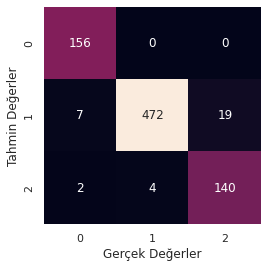

In [ ]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('Gerçek Değerler')
plt.ylabel('Tahmin Değerler')